In [34]:
import os
import pathlib
import random
import tensorflow as tf
import numpy as np
import wave
import pandas as pd
import librosa
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


In [3]:
categories = {i:j for i,j in enumerate(filter(lambda x: x in ['stop', 'up', 'yes', 'down', 'no', 'left', 'right', 'go'],os.listdir(DATASET_PATH)))}
categories

{0: 'go',
 1: 'stop',
 2: 'left',
 3: 'right',
 4: 'up',
 5: 'no',
 6: 'yes',
 7: 'down'}

In [4]:
def load_data(path):
    data = list()
    for idx, folder in categories.items():
        folder_path = os.path.join(path,folder)
        images = os.listdir(folder_path)
        images = [os.path.join(folder_path,image) for image in images]
        for image in images:
            data.append([image,idx])
    return data
data = load_data(DATASET_PATH)

In [5]:
random.shuffle(data)
random.shuffle(data)

In [6]:
def get_sample_rate(d):
    audio_path,label = d
    with wave.open(audio_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        duration = num_frames / sample_rate
    return sample_rate,duration,label

audio_info = [get_sample_rate(d) for d in data]
df = pd.DataFrame(audio_info, columns =['sample_rate', 'duration','label'])

In [7]:
df['label'].value_counts()

label
3    1000
1    1000
4    1000
6    1000
5    1000
7    1000
2    1000
0    1000
Name: count, dtype: int64

In [8]:
df.describe()

,sample_rate,duration,label
count,8000.0,8000.000000,8000.000000
mean,16000.0,0.983703,3.500000
std,0.0,0.061426,2.291431
min,16000.0,0.426687,0.000000
25%,16000.0,1.000000,1.750000
50%,16000.0,1.000000,3.500000
75%,16000.0,1.000000,5.250000
max,16000.0,1.000000,7.000000


In [9]:
def compute_mfcc(audio, sample_rate, n_mfcc=13):
    audio = audio.copy()
    audio[np.isnan(audio)] = 0.0
    audio[np.isinf(audio)] = 0.0
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs.T

def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def process_audio(audio_path,target_length):
    with wave.open(audio_path, 'rb') as wav_file:
        frames = wav_file.readframes(-1)
        num_channels = wav_file.getnchannels()

        numpy_array = np.frombuffer(frames, dtype=np.float32)
        # numpy_array = np.frombuffer(frames, dtype=np.int16)

        if num_channels == 2:
            numpy_array = numpy_array.reshape(-1, 2)

        if len(numpy_array) < target_length:
            padding_length = target_length - len(numpy_array)
            if num_channels == 2:
                numpy_array = np.pad(numpy_array, ((0, padding_length), (0, 0)), 'constant')
            else:
                numpy_array = np.pad(numpy_array, (0, padding_length), 'constant')

        elif len(numpy_array) > target_length:
            numpy_array = numpy_array[:target_length]

        # mfcc = compute_mfcc(numpy_array,target_length)

        return numpy_array.reshape((target_length,1))

In [10]:
def audio_file_to_spectrogram(audio_path, target_length=16000):

    with wave.open(audio_path, 'rb') as wav_file:
        frames = wav_file.readframes(-1)
        audio_array = np.frombuffer(frames, dtype=np.int16)

        if len(audio_array) < target_length:
            padding_length = target_length - len(audio_array)
            audio_array = np.pad(audio_array, (0, padding_length), 'constant')
        elif len(audio_array) > target_length:
            audio_array = audio_array[:target_length]

        _,_, spectrogram = signal.spectrogram(audio_array, fs=wav_file.getframerate())

        return spectrogram

In [11]:
class DataSequence(tf.keras.utils.Sequence):

    def __init__(self,data,batch_size=32,target_length=44100):
        self.data = data
        self.batch_size = batch_size
        self.target_length = target_length

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self,idx):
        batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.data_gen(batch)

    def data_gen(self,data):
        audios,labels = list(),list()
        for audio,label in data:
            aud = audio_file_to_spectrogram(audio,self.target_length)
            audios.append(aud)
            labels.append(label)
        return np.array(audios),np.array(labels)

In [12]:
train_ratio = 0.7
val_ratio = 0.1
total_examples = len(data)
train_size = round(total_examples * train_ratio)
val_size = round(total_examples * val_ratio)
train_examples = data[:train_size]
val_examples = data[train_size:train_size+val_size]
test_examples = data[train_size+val_size:]

In [13]:
batch_size = 32
sample_rate = 16000
train_data = DataSequence(train_examples,batch_size,sample_rate)
test_data = DataSequence(test_examples,1,sample_rate)
eval_data = DataSequence(val_examples,batch_size,sample_rate)

In [14]:
input_shape = (*train_data[0][0].shape[1:],1)
input_shape

(129, 71, 1)

In [15]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=list(train_data[1][0].shape[1:])),

#     tf.keras.layers.Conv1D(32,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Conv1D(32,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Conv1D(64,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling1D(),
#     tf.keras.layers.Dropout(0.25),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dense(128),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dense(64),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(len(categories)),
#     tf.keras.layers.Activation('softmax'),
# ])
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.sparse_categorical_crossentropy,
#     metrics=['accuracy']
# )


In [23]:
def mobilnet_block(x,filters,strides):
  x = tf.keras.layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  return x

_input = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = tf.keras.layers.Dropout(0.5)(x)
x = mobilnet_block(x, filters = 1024, strides = 1)
# x = tf.keras.layers.AvgPool2D(pool_size = 7, strides = 1, data_format='channels_first')(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(categories), activation = 'softmax', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
model = tf.keras.Model(inputs=_input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 129, 71, 1)]      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 65, 36, 32)        320       
                                                                 
 batch_normalization_54 (Ba  (None, 65, 36, 32)        128       
 tchNormalization)                                               
                                                                 
 re_lu_54 (ReLU)             (None, 65, 36, 32)        0         
                                                                 
 depthwise_conv2d_26 (Depth  (None, 65, 36, 32)        320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_55 (Ba  (None, 65, 36, 32)        128 

In [26]:
with tf.device('gpu:0'):
  history = model.fit(train_data,epochs=25,validation_data=eval_data,verbose=1)


Epoch 1/25
175/175 [==============================] - 11s 60ms/step - loss: 0.3037 - accuracy: 0.9095 - val_loss: 3.6441 - val_accuracy: 0.2375
Epoch 2/25
175/175 [==============================] - 8s 46ms/step - loss: 0.2881 - accuracy: 0.9145 - val_loss: 4.2777 - val_accuracy: 0.2062
Epoch 3/25
175/175 [==============================] - 9s 50ms/step - loss: 0.2298 - accuracy: 0.9304 - val_loss: 2.3510 - val_accuracy: 0.3988
Epoch 4/25
175/175 [==============================] - 9s 50ms/step - loss: 0.1939 - accuracy: 0.9475 - val_loss: 3.4053 - val_accuracy: 0.2837
Epoch 5/25
175/175 [==============================] - 8s 46ms/step - loss: 0.2179 - accuracy: 0.9364 - val_loss: 4.0659 - val_accuracy: 0.1950
Epoch 6/25
175/175 [==============================] - 9s 49ms/step - loss: 0.1708 - accuracy: 0.9516 - val_loss: 2.9478 - val_accuracy: 0.3700
Epoch 7/25
175/175 [==============================] - 9s 50ms/step - loss: 0.1674 - accuracy: 0.9489 - val_loss: 7.3090 - val_accuracy: 0.140

In [ ]:
y_true = [i[0] for _,i in test_data]
y_pred = [np.argmax(i) for i in model.predict(test_data)]

In [33]:
conf_mat = tf.math.confusion_matrix(y_true,y_pred)

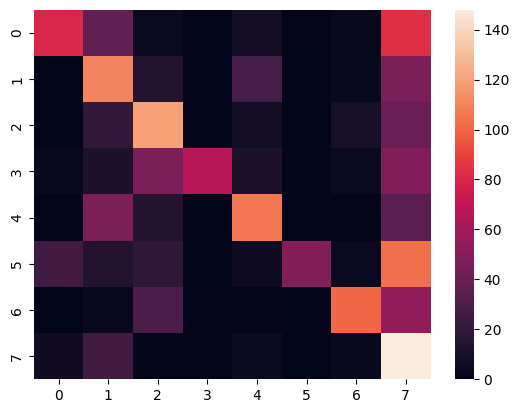

In [35]:
sns.heatmap(conf_mat)
plt.show()

In [36]:
model.save('classifier.h5')
from google.colab import files
files.download('classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>